In [ ]:
import _init_paths
from PIL import Image
import numpy as np
import cv2
import random

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e  import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown
from vcl.models.components.vqvae import VQVAE
from vcl.models.vqvae import VQCL, VQCL_v2
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

import matplotlib.pyplot as plt
%matplotlib inline

target_image_size = 256
save_path = '/homr/lr/reports/12-2/new'

samples = []
with open('/home/lr/dataset/YouTube-VOS/2018/train/test_records.txt', 'r') as f:
    for line in f.readlines():
        name, frame_idx, pixel_idx = line.strip('\n').split()
        samples.append([name, int(frame_idx), int(pixel_idx)])

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

def load_anno():
    video_dir = '/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages'
    list_path = '/home/lr/dataset/YouTube-VOS/2018/train/youtube2018_train_list.txt'

    samples = []

    with open(list_path, 'r') as f:
        for idx, line in enumerate(f.readlines()):
            sample = dict()
            vname, num_frames = line.strip('\n').split()
            sample['frames_path'] = sorted(glob.glob(osp.join(video_dir, vname, '*.jpg')))
            sample['num_frames'] = int(num_frames)
            samples.append(sample)
    return samples

def visualize_vqvae(z1_q, z2_q, frame1, frame2, x_rec1, x_rec2, nembed=2048, rescale=True, mask=None):
    frame_vq_1 = z1_q.permute(1,2,0).numpy()
    frame_vq_2 = z2_q.permute(1,2,0).numpy()

    print(len(np.unique(frame_vq_1)))

    if rescale:
        frame_vq_1 = (frame_vq_1 * 255 / nembed).astype(np.uint8)
        frame_vq_2 = (frame_vq_2 * 255 / nembed).astype(np.uint8)
    else:
        frame_vq_1 = (frame_vq_1).astype(np.uint8)
        frame_vq_2 = (frame_vq_2).astype(np.uint8)

    if mask is not None:

        frame_vq_2 = frame_vq_2 * mask

    plt.rcParams['figure.dpi'] = 200

    plt.figure()

    if x_rec1 is not None:
        plt.subplot(3,2,1)
        plt.imshow(frame_vq_1, cmap=plt.get_cmap('jet'))
        plt.subplot(3,2,2)
        plt.imshow(frame_vq_2, cmap=plt.get_cmap('jet'))

        plt.subplot(3,2,3)
        plt.imshow(np.array(frame1))

        plt.subplot(3,2,4)
        plt.imshow(np.array(frame2))

        plt.subplot(3,2,5)
        plt.imshow(np.array(x_rec1))

        plt.subplot(3,2,6)
        plt.imshow(np.array(x_rec2))

        plt.show()
    else:
        plt.subplot(2,2,1)
        plt.imshow(frame_vq_1, cmap=plt.get_cmap('jet'))
        plt.subplot(2,2,2)
        plt.imshow(frame_vq_2, cmap=plt.get_cmap('jet'))

        plt.subplot(2,2,3)
        plt.imshow(np.array(frame1))

        plt.subplot(2,2,4)
        plt.imshow(np.array(frame2))


def visualize_correspondence(z1_q, z2_q, sample_idx, frame1, frame2, scale=32):
    plt.rcParams['figure.dpi'] = 200

    z1_q = z1_q[0].numpy()
    z2_q = z2_q[0].numpy()
    find = False
    count = 0

    while not find:
        x, y = sample_idx % scale, sample_idx // scale

        query = z1_q[y,x]
        m = (z2_q == query).astype(np.uint8) * 255
        count += 1

        if m.max() > 1:
            find = True
        else:
            # sample_idx = random.randint(0, scale*scale -1)
            sample_idx = random.randint(210, 250)
            print('not find, change query')
        
    print(f"find correspodence at {count}")   

    querys_map = np.zeros((scale,scale))
    querys_map[y,x] = 255
    querys_map = querys_map.astype(np.uint8)
    

    plt.figure()
    plt.subplot(2,2,1)
    plt.imshow(querys_map, cmap=plt.get_cmap('jet'))
    plt.subplot(2,2,2)
    plt.imshow(m, cmap=plt.get_cmap('jet'))
    plt.subplot(2,2,3)
    plt.imshow(np.array(frame1))

    plt.subplot(2,2,4)
    plt.imshow(np.array(frame2))


    
        

Error: Session cannot generate requests

In [ ]:
# sample frame
import os.path as osp
import glob

# samples = load_anno()

# video_idx = random.randint(0, len(samples) - 1)
# frame_idx = random.randint(0, samples[video_idx]['num_frames'] - 2)
# sample = samples[video_idx]

# sample_video_idx = 46
sample_video_idx = random.randint(0, 300)
sample = {}
sample['frames_path'] = sorted(glob.glob(osp.join('/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages', samples[sample_video_idx][0], '*.jpg')))
frame_idx = samples[sample_video_idx][1]
sample_idx = samples[sample_video_idx][2]


frame1 = Image.open(sample['frames_path'][frame_idx]).convert('RGB')
frame2 = Image.open(sample['frames_path'][frame_idx+1]).convert('RGB')
print('sample frames from {}'.format(sample['frames_path'][0]))

x1 = preprocess(frame1)
x2 = preprocess(frame2)

from IPython.display import display, display_markdown

frame1 = T.ToPILImage(mode='RGB')(x1[0])
frame2 = T.ToPILImage(mode='RGB')(x2[0])

sample frames from /home/lr/dataset/YouTube-VOS/2018/train/JPEGImages/4444753edd/00000.jpg


12
12


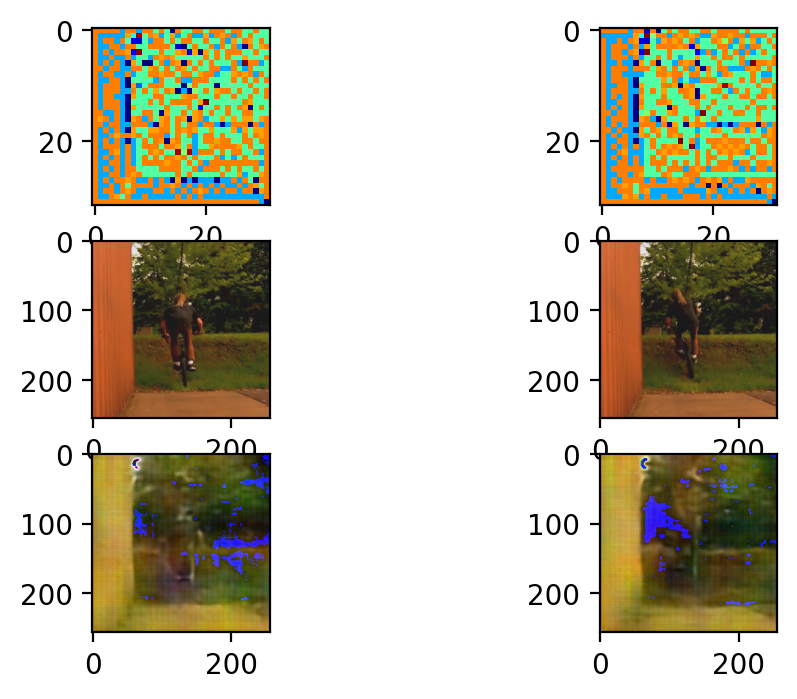

find correspodence at 1


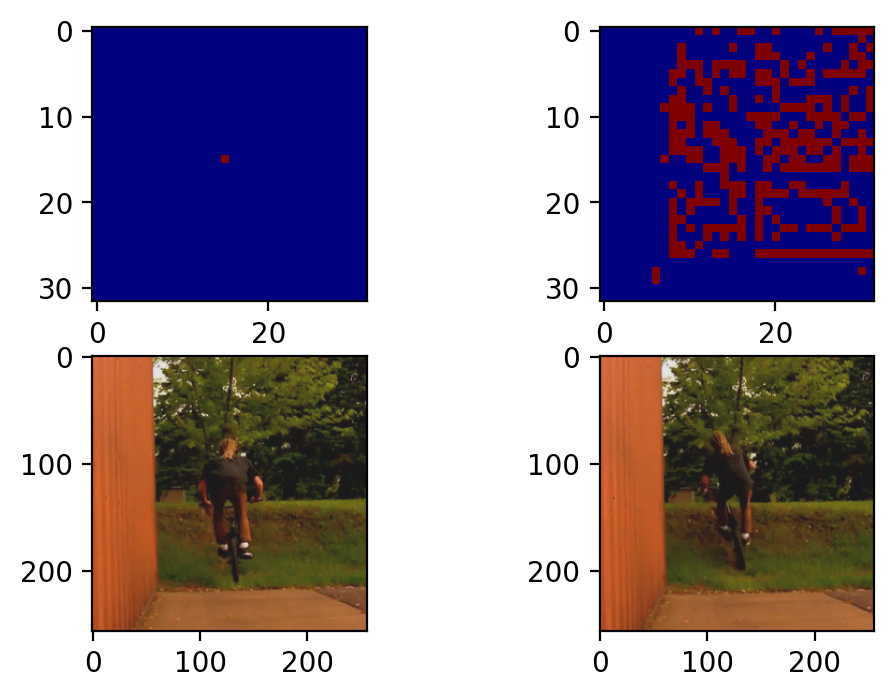

In [ ]:
# encode and decode for origin vqvae
model = VQVAE(downsample=4, n_embed=32, channel=256, n_res_channel=128, embed_dim=128)

model.load_state_dict(torch.load('/home/lr/models/vqvae/vqvae_youtube_d4_n32_c256_embc128.pth'))
model = model.cuda()
model.eval()

_, quant1, diff, ind1, embed = model.encode(x1.cuda())
_, quant2, diff, ind2, embed = model.encode(x2.cuda())

print(len(np.unique(ind1.cpu().numpy())))

dec1 = model.decode(quant1)
dec2 = model.decode(quant2)
dec1 = T.ToPILImage(mode='RGB')(dec1[0].cpu())
dec2 = T.ToPILImage(mode='RGB')(dec2[0].cpu())

visualize_vqvae(ind1.cpu(), ind2.cpu(), frame1, frame2, dec1, dec2, rescale=False)
# visualize corr for origin vqvae
visualize_correspondence(ind1.cpu(), ind2.cpu(), sample_idx, frame1, frame2, scale=32)


7
7


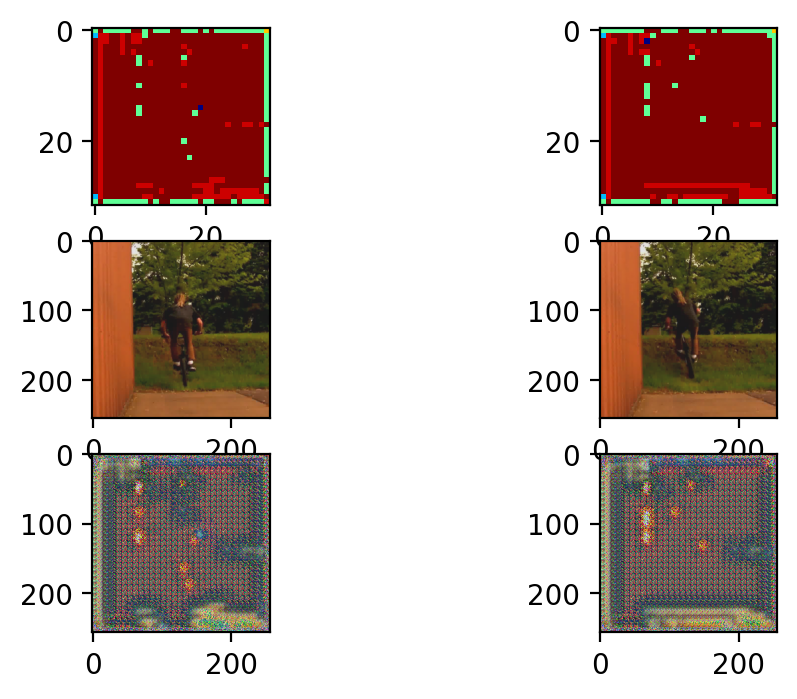

find correspodence at 1


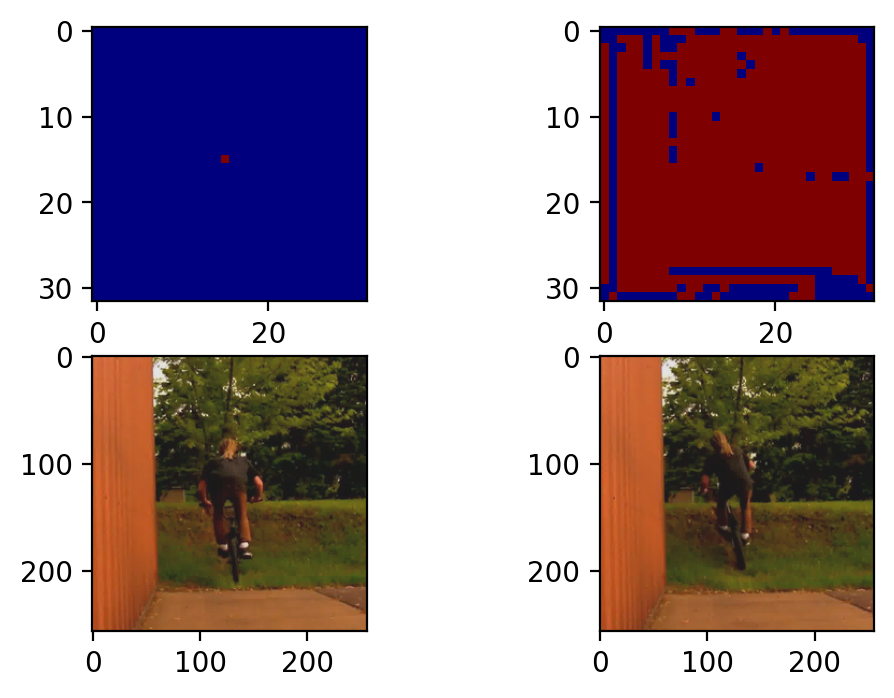

In [ ]:
# encode and decode for origin vqvae
model = VQVAE(downsample=4, n_embed=2048, channel=512, n_res_channel=128, embed_dim=512, newed=True)

model.load_state_dict(torch.load('/home/lr/models/vqvae/vqvae_youtube_d4_n2048_c512_embc512.pth'))
model = model.cuda()
model.eval()

_, quant1, diff, ind1, embed = model.encode(x1.cuda())
_, quant2, diff, ind2, embed = model.encode(x2.cuda())

print(len(np.unique(ind1.cpu().numpy())))

dec1 = model.decode(quant1)
dec2 = model.decode(quant2)
dec1 = T.ToPILImage(mode='RGB')(dec1[0].cpu())
dec2 = T.ToPILImage(mode='RGB')(dec2[0].cpu())

visualize_vqvae(ind1.cpu(), ind2.cpu(), frame1, frame2, dec1, dec2, rescale=False)
# visualize corr for origin vqvae
visualize_correspondence(ind1.cpu(), ind2.cpu(), sample_idx, frame1, frame2, scale=32)

Use load_from_local loader
12
12
find correspodence at 1


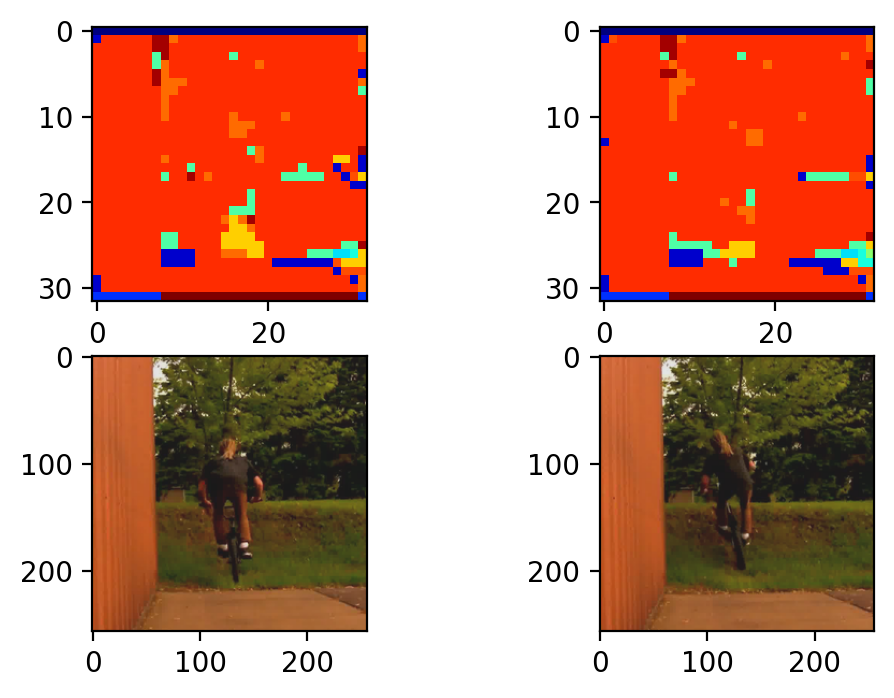

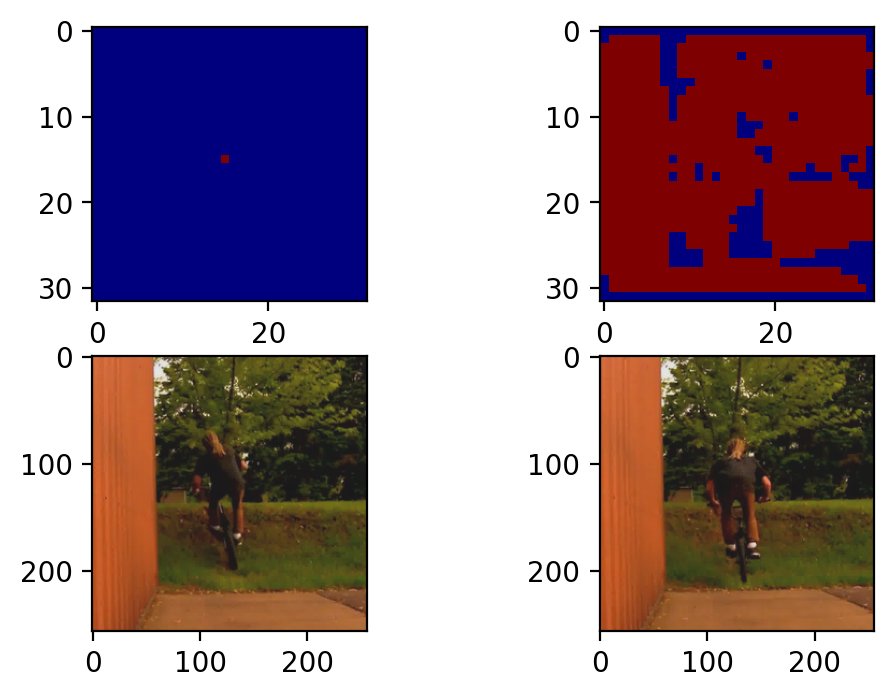

In [ ]:
model = VQCL_v2(backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, )),
    sim_siam_head=dict(
        type='SimSiamHead',
        in_channels=512,
        # norm_cfg=dict(type='SyncBN'),
        num_projection_fcs=3,
        projection_mid_channels=512,
        projection_out_channels=512,
        num_predictor_fcs=2,
        predictor_mid_channels=128,
        predictor_out_channels=512,
        with_norm=True,
        spatial_type='avg'),
    loss=dict(type='CosineSimLoss', negative=False),
    embed_dim=128,
    n_embed=32,
    commitment_cost=1.0,)

_ = load_checkpoint(model, '/home/lr/expdir/VCL/group_vqvae_tracker/train_vqvae_video_d4_nemd32_contrastive_byol_commit1.0/epoch_3200.pth', map_location='cpu')

model = model.cuda()
model.eval()

_, quant1, diff, ind1, embed = model.encode(x1.cuda())
_, quant2, diff, ind2, embed = model.encode(x2.cuda())

print(len(np.unique(ind1.cpu().numpy())))


visualize_vqvae(ind1.cpu(), ind2.cpu(), frame1, frame2, None, None, nembed=32, rescale=False)

visualize_correspondence(ind2.cpu(), ind1.cpu(), sample_idx, frame2, frame1, scale=32)

Use load_from_local loader
3
3
find correspodence at 1


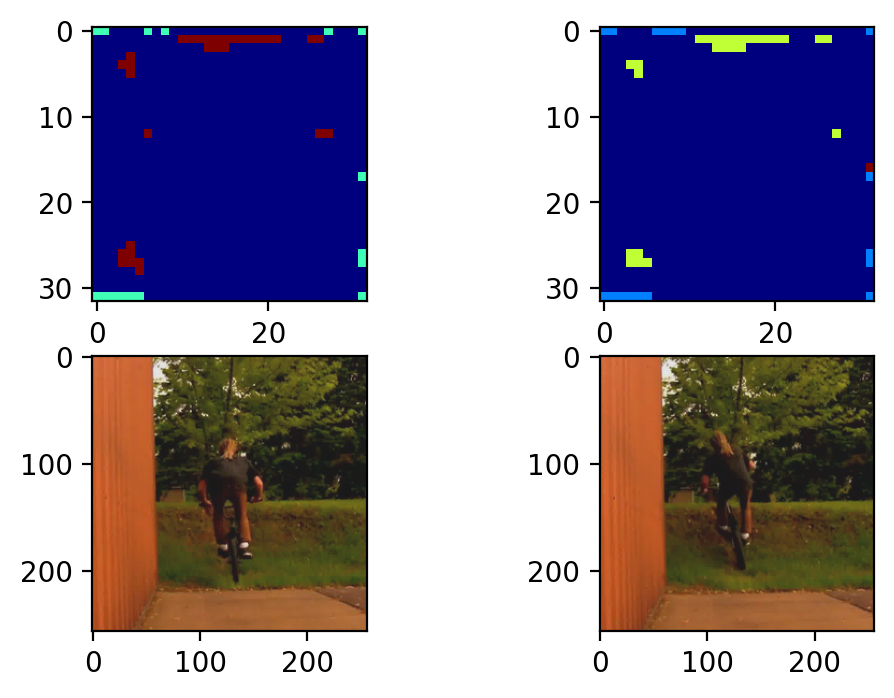

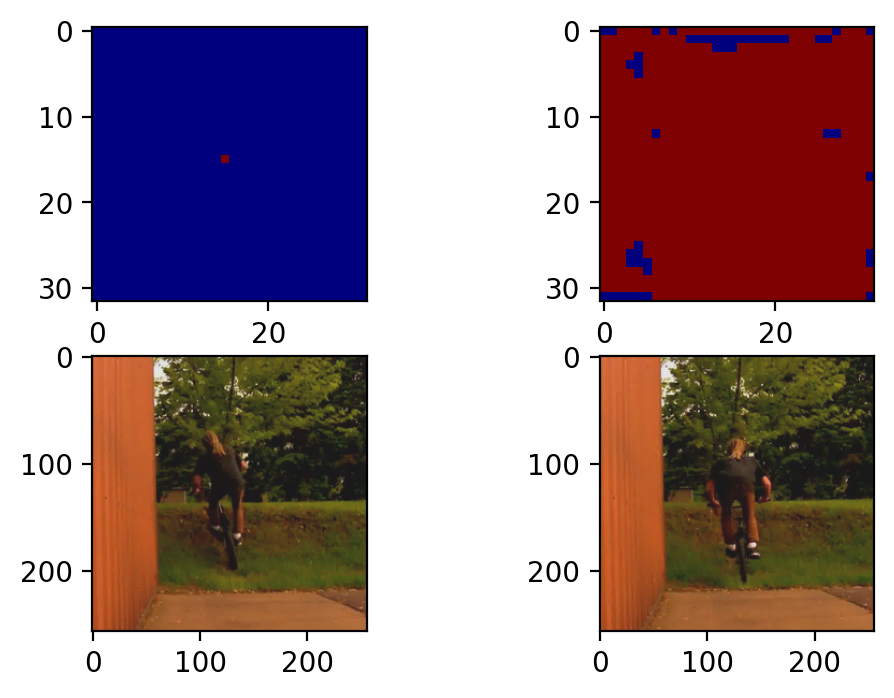

In [ ]:
model = VQCL_v2(backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, )),
    sim_siam_head=dict(
        type='SimSiamHead',
        in_channels=512,
        # norm_cfg=dict(type='SyncBN'),
        num_projection_fcs=3,
        projection_mid_channels=512,
        projection_out_channels=512,
        num_predictor_fcs=2,
        predictor_mid_channels=128,
        predictor_out_channels=512,
        with_norm=True,
        spatial_type='avg'),
    loss=dict(type='CosineSimLoss', negative=False),
    embed_dim=128,
    n_embed=32,
    commitment_cost=1.0,)

_ = load_checkpoint(model, '/home/lr/models/vqvae/vqvae_youtube_d4_n32_c256_embc128_byol_nc_commit1.0.pth', map_location='cpu')

model = model.cuda()
model.eval()

_, quant1, diff, ind1, embed = model.encode(x1.cuda())
_, quant2, diff, ind2, embed = model.encode(x2.cuda())

print(len(np.unique(ind1.cpu().numpy())))


visualize_vqvae(ind1.cpu(), ind2.cpu(), frame1, frame2, None, None, nembed=32, rescale=False)

visualize_correspondence(ind2.cpu(), ind1.cpu(), sample_idx, frame2, frame1, scale=32)